In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
import torch
import torchio as tio

from torch.utils.data import DataLoader

import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

In [3]:
from load_adni.load_adni import load_adni3, load_adni2, load_adni1
# from load_adni.load_oasis import load_oasis1, load_oasis2, load_oasis3, load_oasis4
# from utils.load_seg import load_seg
SEED_VALUE = 103

In [4]:
data = load_adni2(classes={"AD","CN"}, size="half", unique=False, mni=False, dryrun=False)

100%|██████████| 4138/4138 [02:41<00:00, 25.62it/s]


In [5]:
device = torch.device("cuda", 3) if torch.cuda.is_available() else "cpu"
class_dict = {"CN":0,"AD":1}
voxels = [d["voxel"] for d in data]
labels = [class_dict[d["class"]] for d in data]
pids = [d["pid"] for d in data]

In [6]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)
tid, vid = list(sgkf.split(voxels, labels, pids))[0]
tvoxels = [voxels[i] for i in tid]
tlabels = [labels[i] for i in tid]
vvoxels = [voxels[i] for i in vid]
vlabels = [labels[i] for i in vid]

In [9]:
from torch.utils.data import Dataset


class BrainDataset(Dataset):
    def __init__(self, voxels, labels, transform=None):
        self.voxels = [self.preprocessing(voxel) for voxel in tqdm(voxels)]
        self.labels = labels
        self.transform = transform # data aug 追加

    def _normalize(self, x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))
    def preprocessing(self, voxel):
        nonzero = voxel[voxel>0]
        voxel = np.clip(voxel, 0, np.mean(nonzero)+3*np.std(nonzero))
        voxel = self._normalize(voxel)
        return voxel
    def __len__(self):
        return len(self.voxels)
    
    def __getitem__(self, idx):
        voxel = self.voxels[idx]
        label = self.labels[idx]
        if self.transform:
            voxel = self.transform(voxel)
        return voxel[np.newaxis].astype("float32"), label

In [11]:
split_index = 4
augment_flag = True
batch_size = 32
print(f"fold number={split_index}   Augment={augment_flag}", end="  ")
if augment_flag: # TrueならAugmentation実行, Falseなら実行しない
    spatial_transforms = {# soft-introだと30°は回転の影響が大き過ぎるかも
        tio.transforms.RandomAffine(degrees=(5.0, 0.0, 0.0)): 0.340,
        tio.transforms.RandomAffine(degrees=(0.0, 5.0, 0.0)): 0.330,
        tio.transforms.RandomAffine(degrees=(0.0, 0.0, 5.0)): 0.330,
    }
    transform = tio.Compose([
        tio.OneOf(spatial_transforms, p=0.6),
    ])
    train_dataset = BrainDataset(tvoxels, tlabels, transform=transform,)
    val_dataset = BrainDataset(vvoxels, vlabels, transform=None,)
else:
    train_dataset = BrainDataset(tvoxels, tlabels, transform=None,)
    val_dataset = BrainDataset(vvoxels, vlabels, transform=None,)


g = torch.Generator()
g.manual_seed(SEED_VALUE)

print(f"batch size:{batch_size}", end="  ")


fold number=4   Augment=True  

100%|██████████| 858/858 [00:05<00:00, 161.39it/s]

batch size:32  

In [12]:
# train_dataset = BrainDataset(tvoxels, tlabels)
# val_dataset = BrainDataset(vvoxels[:10], vlabels[:10])

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, pool=True):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool3d(2,2)
    def forward(self, x):
        if self.pool:
            return self.pool(self.block(x))
        else:
            return self.block(x)
        
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.blocks1 = Block(1, 3)
        self.blocks2 = Block(3, 3)
        self.blocks3 = Block(3, 8)
        self.blocks4 = Block(8, 8)
        
        self.fc1 = nn.Linear(5 * 7 * 5 * 8, 64)
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.blocks1(x)
        x = self.blocks2(x)
        x = self.blocks3(x)
        x = self.blocks4(x)
        _, c, h, w, z = x.shape
        x = x.view(-1, h * w * z * c)
        x = self.fc1(self.dropout(x))
        x = self.fc2(self.dropout(x))
        return x

In [15]:
model = CNN()
#model.load_state_dict(torch.load("result/model.pth"))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler(enabled=True)

In [16]:
tlosses = []
vlosses = []
for epoch in tqdm(range(100)):
    trun_loss = 0
    vrun_loss = 0
    model.train()
    for voxels, labels in train_loader:
        voxels = voxels.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with autocast(enabled=True):
            pred = model(voxels)
            loss = criterion(pred, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        trun_loss+=loss.item()
    trun_loss/=len(train_loader)
    tlosses.append(trun_loss)

    model.eval()
    for voxels, labels in val_loader:
        voxels = voxels.to(device)
        labels = labels.to(device)
        with autocast(enabled=True):
            pred = model(voxels)
            loss = criterion(pred, labels)
        vrun_loss+=loss.item()
    vrun_loss/=len(val_loader)
    vlosses.append(vrun_loss)

    if epoch % 10 == 0:
        print(trun_loss)
        print(vrun_loss)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_38434/4187143926.py", line 24, in __getitem__
    voxel = self.transform(voxel)
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torchio/transforms/transform.py", line 150, in __call__
    transformed = self.apply_transform(subject)
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torchio/transforms/augmentation/composition.py", line 47, in apply_transform
    subject = transform(subject)
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torchio/transforms/transform.py", line 150, in __call__
    transformed = self.apply_transform(subject)
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torchio/transforms/augmentation/composition.py", line 109, in apply_transform
    transformed = transform(subject)
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torchio/transforms/transform.py", line 139, in __call__
    subject = data_parser.get_subject()
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torchio/transforms/data_parser.py", line 56, in get_subject
    subject = self._parse_tensor(self.data)
  File "/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/torchio/transforms/data_parser.py", line 116, in _parse_tensor
    raise ValueError(message)
ValueError: The input must be a 4D tensor with dimensions (channels, x, y, z) but it has shape (80, 112, 80). Tips: if it is a volume, please add the channels dimension; if it is 2D, also add a dimension of size 1 for the z axis


In [12]:
torch.save(model.cpu().state_dict(), "result/ADCN.pth")

In [30]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

pred_list = []
model.to(device)
model.eval()
for voxel in tqdm(vvoxels):
    voxel = np.clip(voxel, 0, 4*np.std(voxel))
    voxel = normalize(voxel)[np.newaxis][np.newaxis].astype("float32")
    voxel = torch.tensor(voxel, requires_grad=False).to(device)
    pred = model(voxel).cpu().detach().numpy()
    pred = np.argmax(pred)
    pred_list.append(pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 88.40it/s]


0.7675459891028753
0.7769784172661871


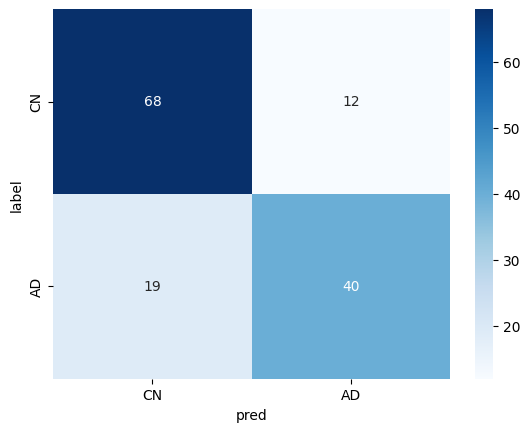

In [31]:
cm = confusion_matrix(vlabels, pred_list)
cm = pd.DataFrame(data=cm, index=["CN", "AD"], columns=["CN", "AD"])
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("pred")
plt.ylabel("label")
print(f1_score(vlabels, pred_list, average="macro"))
print(accuracy_score(vlabels, pred_list))

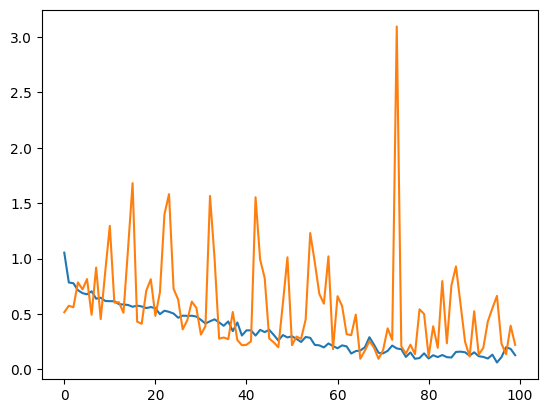

In [32]:
plt.plot(tlosses)
plt.plot(vlosses)